In [1]:
# Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table align="left">

  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/notebook_template.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/notebook_template.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-managed-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/notebook_template.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>                                                                                               
</table>

## Overview

This notebook demonstrates how you ingest, analyze, and write back data to BigQuery using Apache Spark on Dataproc Serverless. Using the GitHub Activity Data, we will analyze repositories in GitHub and find out what kind of programming languages being used in their repositories.

### Dataset

The dataset we are using is the [GitHub Activity Data](https://console.cloud.google.com/marketplace/product/github/github-repos), available in [BigQuery Public Datasets](https://cloud.google.com/bigquery/public-data). The first 1TB of data queried each month is free.

### Objective

This notebook demonstrates Apache Spark jobs that fetch data from BigQuery, analyze it, and write the results back to BigQuery. Through this process, we can learn a common use case in data engineering: ingesting data from a database, performing transformations during preprocessing, and writing back to another database. We also learn how to submit Apache Spark jobs in the Dataproc Serverless environment on Google Cloud Platform. 

In this project, these questions below will be answered.

- Which language is the most frequently used among the monoglot repos?
- What is the average size of each language among the monoglot repos?
- Given a language, which other languages are most frequently found in polyglot repos with it?

Note: repositories that encompass polyglot programming are referred to as polyglot repos and those which only contain one programming language are referred to as monoglot repos.


The steps performed include the following:

- Setting up the serverless environment.
- Configuring spark-bigquery-connector.
- Ingesting data from BigQuery to Spark DataFrame.
- Preprocessing ingested data.
- Analyze that the most frequently used programming language among the monoglot repos.
- Analyze that the average size of each language among the monoglot repos.
- Analyze that the most frequently used languages with a given language in polyglot repos.
- Write the result back to BigQuery
- Delete Dataproc Serverless Session
- Disable APIs being used in the project.

### Costs 

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage
* Dataproc Serverless

Learn about [Vertex AI
pricing](https://cloud.google.com/vertex-ai/pricing), [Cloud Storage
pricing](https://cloud.google.com/storage/pricing), [Dataproc Serverless pricing](https://cloud.google.com/dataproc-serverless/pricing)
and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

### Set up your local development environment

**If you are using Colab or Vertex AI Workbench Notebooks**, your environment already meets
all the requirements to run this notebook. You can skip this step.

**Otherwise**, make sure your environment meets this notebook's requirements.
You need the following:

* The Google Cloud SDK
* Git
* Python 3
* virtualenv
* Jupyter notebook running in a virtual environment with Python 3

The Google Cloud guide to [Setting up a Python development
environment](https://cloud.google.com/python/setup) and the [Jupyter
installation guide](https://jupyter.org/install) provide detailed instructions
for meeting these requirements. The following steps provide a condensed set of
instructions:

1. [Install and initialize the Cloud SDK.](https://cloud.google.com/sdk/docs/)

1. [Install Python 3.](https://cloud.google.com/python/setup#installing_python)

1. [Install
   virtualenv](https://cloud.google.com/python/setup#installing_and_using_virtualenv)
   and create a virtual environment that uses Python 3. Activate the virtual environment.

1. To install Jupyter, run `pip3 install jupyter` on the
command-line in a terminal shell.

1. To launch Jupyter, run `jupyter notebook` on the command-line in a terminal shell.

1. Open this notebook in the Jupyter Notebook Dashboard.

### Install additional packages

Install the following packages required to execute this notebook. 

{TODO: Suggest using the latest major GA version of each package; i.e., --upgrade}

In [ ]:
import os

# The Vertex AI Workbench Notebook product has specific requirements
IS_WORKBENCH_NOTEBOOK = os.getenv("DL_ANACONDA_HOME")
IS_USER_MANAGED_WORKBENCH_NOTEBOOK = os.path.exists(
    "/opt/deeplearning/metadata/env_version"
)

# Vertex AI Notebook requires dependencies to be installed with '--user'
USER_FLAG = ""
if IS_WORKBENCH_NOTEBOOK:
    USER_FLAG = "--user"

! pip3 install --upgrade google-cloud-aiplatform {USER_FLAG} -q
# TODO: Add remaining package installs here

### Restart the kernel

After you install the additional packages, you need to restart the notebook kernel so it can find the packages.

In [ ]:
# Automatically restart kernel after installs
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

## Before you begin

### Set up your Google Cloud project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

1. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

1. [Enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com). {TODO: Update the APIs needed for your tutorial. Edit the API names, and update the link to append the API IDs, separating each one with a comma. For example, container.googleapis.com,cloudbuild.googleapis.com}

1. If you are running this notebook locally, you will need to install the [Cloud SDK](https://cloud.google.com/sdk).

1. Enter your project ID in the cell below. Then run the cell to make sure the
Cloud SDK uses the right project for all the commands in this notebook.

**Note**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$` into these commands.

#### Set your project ID

**If you don't know your project ID**, you may be able to get your project ID using `gcloud`.

In [ ]:
PROJECT_ID = ""

# Get your Google Cloud project ID from gcloud
if not os.getenv("IS_TESTING"):
    shell_output = !gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID: ", PROJECT_ID)

Otherwise, set your project ID here.

In [ ]:
if PROJECT_ID == "" or PROJECT_ID is None:
    PROJECT_ID = "[your-project-id]"  # @param {type:"string"}

In [ ]:
! gcloud config set project $PROJECT_ID

#### Get your project number {TODO: Include these cells if the notebook uses a project number}

Now that the project ID is set, you get your corresponding project number.

In [ ]:
shell_output = ! gcloud projects list --filter="PROJECT_ID:'{PROJECT_ID}'" --format='value(PROJECT_NUMBER)'
PROJECT_NUMBER = shell_output[0]
print("Project Number:", PROJECT_NUMBER)

#### Region

You can also change the `REGION` variable, which is used for operations
throughout the rest of this notebook.  Below are regions supported for Vertex AI. We recommend that you choose the region closest to you.

- Americas: `us-central1`
- Europe: `europe-west4`
- Asia Pacific: `asia-east1`

You may not use a multi-regional bucket for training with Vertex AI. Not all regions provide support for all Vertex AI services.

Learn more about [Vertex AI regions](https://cloud.google.com/vertex-ai/docs/general/locations).

In [ ]:
REGION = "[your-region]"  # @param {type: "string"}

if REGION == "[your-region]":
    REGION = "us-central1"

#### Timestamp

If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, you create a timestamp for each instance session, and append it onto the name of resources you create in this tutorial.

In [ ]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

### Authenticate your Google Cloud account

**If you are using Vertex AI Workbench Notebooks**, your environment is already
authenticated. Skip this step.

**If you are using Colab**, run the cell below and follow the instructions
when prompted to authenticate your account via oAuth.

**Otherwise**, follow these steps:

1. In the Cloud Console, go to the [**Create service account key**
   page](https://console.cloud.google.com/apis/credentials/serviceaccountkey).

2. Click **Create service account**.

3. In the **Service account name** field, enter a name, and
   click **Create**.

4. In the **Grant this service account access to project** section, click the **Role** drop-down list. Type "Vertex AI"
into the filter box, and select
   **Vertex AI Administrator**. Type "Storage Object Admin" into the filter box, and select **Storage Object Admin**.

5. Click *Create*. A JSON file that contains your key downloads to your
local environment.

6. Enter the path to your service account key as the
`GOOGLE_APPLICATION_CREDENTIALS` variable in the cell below and run the cell.

In [2]:
# If you are running this notebook in Colab, run this cell and follow the
# instructions to authenticate your GCP account. This provides access to your
# Cloud Storage bucket and lets you submit training jobs and prediction
# requests.

import os
import sys

# If on Vertex AI Workbench, then don't execute this code
IS_COLAB = "google.colab" in sys.modules
if not os.path.exists("/opt/deeplearning/metadata/env_version") and not os.getenv(
    "DL_ANACONDA_HOME"
):
    if "google.colab" in sys.modules:
        from google.colab import auth as google_auth

        google_auth.authenticate_user()

    # If you are running this notebook locally, replace the string below with the
    # path to your service account key and run this cell to authenticate your GCP
    # account.
    elif not os.getenv("IS_TESTING"):
        %env GOOGLE_APPLICATION_CREDENTIALS ''

env: GOOGLE_APPLICATION_CREDENTIALS=''


### Create a Cloud Storage bucket

**The following steps are required, regardless of your notebook environment.**


{TODO: Adjust wording in the first paragraph to fit your use case - explain how your tutorial uses the Cloud Storage bucket. The example below shows how Vertex AI uses the bucket for training.}

When you submit a training job using the Cloud SDK, you upload a Python package
containing your training code to a Cloud Storage bucket. Vertex AI runs
the code from this package. In this tutorial, Vertex AI also saves the
trained model that results from your job in the same bucket. Using this model artifact, you can then
create Vertex AI model and endpoint resources in order to serve
online predictions.

Set the name of your Cloud Storage bucket below. It must be unique across all
Cloud Storage buckets.

In [ ]:
BUCKET_NAME = "[your-bucket-name]"  # @param {type:"string"}
BUCKET_URI = f"gs://{BUCKET_NAME}"

In [ ]:
if BUCKET_NAME == "" or BUCKET_NAME is None or BUCKET_NAME == "[your-bucket-name]":
    BUCKET_NAME = PROJECT_ID + "aip-" + TIMESTAMP
    BUCKET_URI = f"gs://{BUCKET_NAME}"

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [ ]:
! gsutil mb -l $REGION -p $PROJECT_ID $BUCKET_URI

Finally, validate access to your Cloud Storage bucket by examining its contents:

In [ ]:
! gsutil ls -al $BUCKET_URI

#### Service Account {TODO: Include these cells if the notebook specifies a service account}

{TODO: What uses service account in the notebook; e.g., You use a service account to create Vertex AI Pipeline jobs.}. If you do not want to use your project's Compute Engine service account, set `SERVICE_ACCOUNT` to another service account ID.

In [ ]:
SERVICE_ACCOUNT = "[your-service-account]"  # @param {type:"string"}

In [ ]:
if (
    SERVICE_ACCOUNT == ""
    or SERVICE_ACCOUNT is None
    or SERVICE_ACCOUNT == "[your-service-account]"
):
    # Get your service account from gcloud
    if not IS_COLAB:
        shell_output = !gcloud auth list 2>/dev/null
        SERVICE_ACCOUNT = shell_output[2].replace("*", "").strip()

    else:  # IS_COLAB:
        shell_output = ! gcloud projects describe  $PROJECT_ID
        project_number = shell_output[-1].split(":")[1].strip().replace("'", "")
        SERVICE_ACCOUNT = f"{project_number}-compute@developer.gserviceaccount.com"

    print("Service Account:", SERVICE_ACCOUNT)

#### Set service account access for {TODO; e.g., Vertex AI Pipelines}

Run the following commands to grant your service account access to {TODO; i.e., read and write pipeline artifacts} in the bucket that you created in the previous step. You only need to run this step once per service account.

In [ ]:
! gsutil iam ch serviceAccount:{SERVICE_ACCOUNT}:roles/storage.objectCreator $BUCKET_URI

! gsutil iam ch serviceAccount:{SERVICE_ACCOUNT}:roles/storage.objectViewer $BUCKET_URI

## Tutorial

### Import required libraries

In [92]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import size, col, UserDefinedFunction, explode
from pyspark.sql.types import ArrayType, FloatType, StringType
from itertools import combinations

### Initialize the SparkSession and fetch data from BigQuery

In [93]:
#!/usr/bin/python
"""BigQuery I/O PySpark example."""
spark = SparkSession.builder \
    .appName('spark-bigquery-polyglot-language-demo') \
    .config('spark.jars', 'gs://spark-lib/bigquery/spark-bigquery-with-dependencies_2.12-0.25.2.jar') \
    .getOrCreate()

# Load data from BigQuery.
df = spark.read.format('bigquery') \
  .option('table', 'bigquery-public-data.github_repos.languages') \
  .load()

### Preprocessing

In [94]:
# Define constants for further use.
LIMIT = 10
EXPLODE_PIE_CHART = tuple([.05] * LIMIT)

def array_to_mono_language(arr) -> str:
    if len(arr) != 1:
        return None
    return arr[0].name

def array_to_mono_size(arr) -> int:
    if len(arr) != 1:
        return 0
    return arr[0].bytes

def array_to_poly_language(arr) -> str:
    if len(arr) < 2:
        return None
    arr.sort(key=lambda x : -x.bytes)
    sub = arr[:3]
    sub.sort(key=lambda x : x.name)
    ret = []
    for elem in sub:
        ret.append(elem.name)
    return ', '.join(ret)

udf_map = {
    "mono_language": array_to_mono_language,
    "mono_size": array_to_mono_size,
    "poly_language": array_to_poly_language,
}

preprocessed_df = df.alias("preprocessed_df")
for name, udf in udf_map.items():
    preprocessed_df = preprocessed_df.withColumn(name, UserDefinedFunction(udf)(col("language")))
preprocessed_df = preprocessed_df.drop("language")

In [95]:
preprocessed_df.createOrReplaceTempView('df_view')
preprocessed_df.printSchema()
preprocessed_df.show()
# See the number of repositories of monoglot(single language used) and polyglot(multiple languages used).
mono = preprocessed_df.where(size(col("language")) == 1).count()
poly = preprocessed_df.where(size(col("language")) > 1).count()
print(f"The number of repositories that use only one language is {mono}")
print(f"The number of repositories that use multiple language is {poly}")

root
 |-- repo_name: string (nullable = true)
 |-- mono_language: string (nullable = true)
 |-- mono_size: string (nullable = true)
 |-- poly_language: string (nullable = true)

+--------------------+-------------+---------+-------------+
|           repo_name|mono_language|mono_size|poly_language|
+--------------------+-------------+---------+-------------+
|kamilmowinski/scr...|            C|      250|         null|
|davidlau325/ChatRoom|            C|    40530|         null|
|navinsoni/Device_...|            C|    15136|         null|
|mcomp2010-school/...|            C|     2829|         null|
|      ZekeMill/pset3|            C|     5906|         null|
|     fumyuun/coffeed|            C|     3838|         null|
|      pollo89/pdroll|            C|     1194|         null|
|   duncanthrax/pdkim|            C|   240159|         null|
|jean-edouard/libx...|            C|    32840|         null|
|raghumdani/ubuntu...|            C|    18359|         null|
|pavelvpster/OpenW...|       

The number of repositories that use only one language is 1203335
The number of repositories that use multiple language is 1752486


+-------------+------+
|mono_language|   cnt|
+-------------+------+
|   JavaScript|203852|
|       Python|191097|
|         Java|183309|
|         Ruby|106330|
|          PHP| 96086|
|           C#| 57749|
|        Shell| 56176|
|           Go| 42846|
|  Objective-C| 22484|
|          C++| 21984|
|         HTML| 20729|
|            C| 16377|
|      Haskell| 15985|
|      Clojure| 12225|
|        Swift| 10898|
|        Scala| 10756|
|          CSS| 10619|
|            R|  9043|
|         Perl|  8883|
|         Rust|  8314|
+-------------+------+
only showing top 20 rows



<AxesSubplot:ylabel='cnt'>

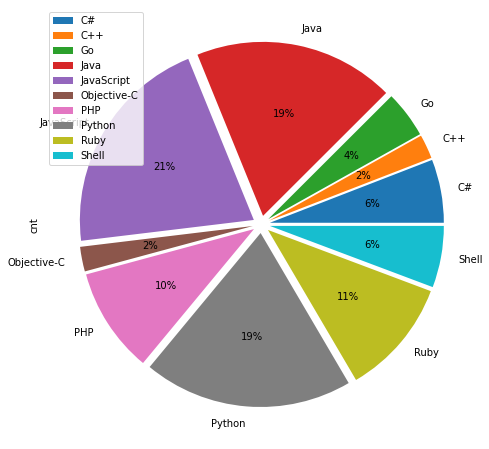

In [23]:
# Sort the monoglot repositories by the popularity of languages and see the top 10 languages.
mono_ranking = spark.sql("""
    SELECT
        df_view.mono_language,
        count(df_view.mono_language) AS `cnt`
    FROM
        df_view
    GROUP BY
        df_view.mono_language
    ORDER BY
        `cnt` DESC
""")

mono_ranking.show()
mono_panda = mono_ranking.toPandas()[:LIMIT].copy()
mono_panda.groupby(['mono_language']) \
        .sum() \
        .plot( \
            kind='pie', \
            y='cnt', \
            autopct='%1.0f%%', \
            figsize=(8, 8), \
            explode=EXPLODE_PIE_CHART \
        )

In [24]:
# Get the average size in MegaBytes of each monoglot repositories and sort by it's size
mono_ranking_avg_bytes = spark.sql("""
    SELECT
        df_view.mono_language, 
        round(avg(df_view.mono_size/1000)) AS `average(MB)`,
        count(df_view.mono_language) AS `cnt`
    FROM 
        df_view
    GROUP BY df_view.mono_language
    ORDER BY
        `average(MB)` DESC
""")
mono_ranking_avg_bytes = mono_ranking_avg_bytes.filter(col('cnt') > 100)
mono_ranking_avg_bytes.show()

+----------------+-----------+-----+
|   mono_language|average(MB)|  cnt|
+----------------+-----------+-----+
|     Mathematica|     4447.0|  244|
|Jupyter Notebook|     2224.0| 2539|
|       Pure Data|     1585.0|  132|
|           Eagle|     1322.0|  349|
|             Max|     1046.0|  112|
|           KiCad|      551.0|  266|
|            HTML|      547.0|20729|
|         PLpgSQL|      447.0|  121|
|           PLSQL|      427.0|  208|
|           Groff|      426.0|  110|
|          Pascal|      358.0| 1263|
|          AutoIt|      297.0|  266|
|       Smalltalk|      290.0|  145|
|              C#|      224.0|57749|
|    ActionScript|      224.0| 1420|
|    Visual Basic|      217.0| 2309|
|             IDL|      208.0|  146|
|          MATLAB|      178.0|  463|
|             Lua|      174.0| 7892|
|        Assembly|      165.0|  763|
+----------------+-----------+-----+
only showing top 20 rows



+--------------------+------+
|       poly_language|   cnt|
+--------------------+------+
|CSS, HTML, JavaSc...|250751|
|CSS, JavaScript, PHP| 71307|
|     CSS, JavaScript| 60490|
|    HTML, JavaScript| 53499|
|       Python, Shell| 33754|
|           CSS, HTML| 26946|
|     CSS, HTML, Ruby| 25045|
|HTML, JavaScript,...| 22133|
|   Objective-C, Ruby| 21533|
|HTML, JavaScript,...| 19861|
|         Ruby, Shell| 19757|
|CSS, JavaScript, ...| 18015|
|CSS, JavaScript, ...| 16895|
|    Assembly, C, C++| 14933|
|              C, C++| 13912|
|      CSS, HTML, PHP| 13059|
|CSS, Java, JavaSc...| 13025|
|      C, C++, Python| 12877|
|   CSS, HTML, Python| 12718|
|         Java, Shell| 11965|
+--------------------+------+
only showing top 20 rows



<AxesSubplot:ylabel='cnt'>

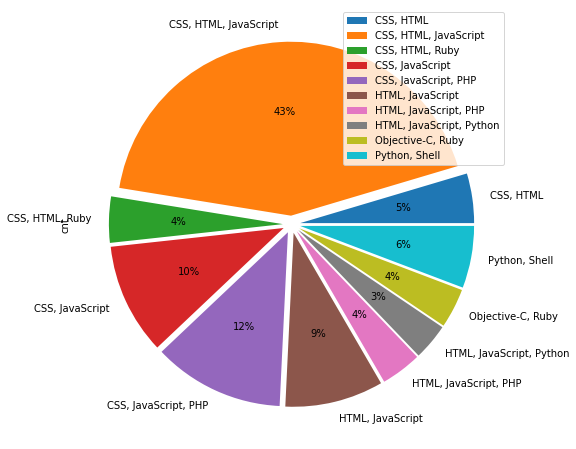

In [26]:
poly_ranking = spark.sql("""
    SELECT
        df_view.poly_language,
        count(df_view.poly_language) AS cnt
    FROM
        df_view
    GROUP BY df_view.poly_language
    ORDER BY
        cnt DESC
""")
poly_ranking.show()

poly_panda = poly_ranking.toPandas()[:LIMIT].copy()
poly_panda.groupby(['poly_language']) \
        .sum() \
        .plot( \
            kind='pie', \
            y='cnt', \
            autopct='%1.0f%%', \
            figsize=(8, 8), \
            explode=EXPLODE_PIE_CHART \
        )

In [97]:
def preprocess_reduce_language(arr):
    if len(arr) < 2:
        return None
    languages = []
    for language in arr:
        languages.append(language.name)
    return languages

def preprocess_combination(arr):
    if not arr:
        return None
    arr_combinations = []
    for combination in combinations(arr, 2):
        arr_combinations.append(combination)
        arr_combinations.append(combination[::-1])
    return arr_combinations

df = df.withColumn(
        "reduced_languages",
        UserDefinedFunction(
            preprocess_reduce_language,
            ArrayType(StringType())
        )(col("language"))
    )
df = df.withColumn(
        "combinations",
        UserDefinedFunction(
            preprocess_combination, 
            ArrayType(ArrayType(StringType()))
        )(col("reduced_languages"))
    )

frequency_df = df.select(col("repo_name"), col("combinations")).where(size(col("language")) > 1)
frequency_df = frequency_df.withColumn("languages", explode(col("combinations")))
frequency_df = frequency_df.withColumn("lang0", col('languages')[0])
frequency_df = frequency_df.withColumn("lang1", col('languages')[1])
frequency_df = frequency_df.crosstab("lang0", "lang1")
frequency_df = frequency_df.withColumn("languages", col("lang0_lang1"))
frequency_df = frequency_df.drop("lang0_lang1")
frequency_df.createOrReplaceTempView('frequency_df_view')

In [103]:
MAJOR_LANGUAGES = {"C", "C++", "Java", "Python", "JavaScript", "Go"}
df_arr = []

# py_df = spark.sql('''
#     SELECT languages, `Python` from frequency_df_view ORDER BY `python` DESC LIMIT 20
# ''')
# py_df.show()

# test = frequency_df.select(col("languages"), col("Python")).sort(-col("Python")).limit(20)
# test.show()
for language in MAJOR_LANGUAGES:
    df_arr.append(frequency_df.select(col("languages"), language).sort(-col(language)).limit(20))
for i in df_arr:
    i.show()

+-------------+------+
|    languages|     C|
+-------------+------+
|          C++|182071|
|        Shell|156292|
|     Makefile|116809|
|       Python|103242|
|  Objective-C| 85357|
|         Perl| 52055|
|   JavaScript| 48443|
|         HTML| 48300|
|     Assembly| 42970|
|          CSS| 42009|
|        CMake| 37291|
|         Java| 33530|
|         Ruby| 31049|
|    Batchfile| 29748|
|        Groff| 18723|
|          Awk| 18643|
|          PHP| 17915|
|           C#| 16739|
|Objective-C++| 15460|
|           M4| 13868|
+-------------+------+

+-----------+------+
|  languages|Python|
+-----------+------+
|      Shell|209842|
| JavaScript|127040|
|       HTML|124631|
|        CSS|112778|
|          C|103242|
|   Makefile|101581|
|        C++| 96582|
|       Perl| 48474|
|Objective-C| 47495|
|       Java| 41362|
|  Batchfile| 34982|
|       Ruby| 34309|
|   Assembly| 30321|
|        PHP| 27707|
|      CMake| 24114|
|        Awk| 17019|
|      Groff| 16196|
|        TeX| 15305|
|     

## General style examples

### Notebook heading

- Include the collapsed license at the top (this uses Colab's "Form" mode to hide the cells).
- Only include a single H1 title.
- Include the button-bar immediately under the H1.
- Check that the Colab and GitHub links at the top are correct.

### Notebook sections

- Use H2 (##) and H3 (###) titles for notebook section headings.
- Use [sentence case to capitalize titles and headings](https://developers.google.com/style/capitalization#capitalization-in-titles-and-headings). ("Train the model" instead of "Train the Model")
- Include a brief text explanation before any code cells.
- Use short titles/headings: "Download the data", "Build the model", "Train the model".

### Writing style

- Use [present tense](https://developers.google.com/style/tense). ("You receive a response" instead of "You will receive a response")
- Use [active voice](https://developers.google.com/style/voice). ("The service processes the request" instead of "The request is processed by the service")
- Use [second person](https://developers.google.com/style/person) and an imperative style. 
    - Correct examples: "Update the field", "You must update the field"
    - Incorrect examples: "Let's update the field", "We'll update the field", "The user should update the field"
- **Googlers**: Please follow our [branding guidelines](http://goto/cloud-branding).

### Code

- Put all your installs and imports in a setup section.
- Save the notebook with the Table of Contents open.
- Write Python 3 compatible code.
- Follow the [Google Python Style guide](https://github.com/google/styleguide/blob/gh-pages/pyguide.md) and write readable code.
- Keep cells small (max ~20 lines).

## TensorFlow code style

Use the highest level API that gets the job done (unless the goal is to demonstrate the low level API). For example, when using Tensorflow:

- Use TF.keras.Sequential > keras functional api > keras model subclassing > ...

- Use  model.fit > model.train_on_batch > manual GradientTapes.

- Use eager-style code.

- Use tensorflow_datasets and tf.data where possible.

### Notebook code style examples

 - Notebooks are for people. Write code optimized for clarity.

 - Demonstrate small parts before combining them into something more complex. Like below:

In [ ]:
# install needed for notebook ingestion test; otherwise not part of the example
! pip3 install --upgrade tensorflow

# Build the model
import tensorflow as tf

model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(10, activation="relu", input_shape=(None, 5)),
        tf.keras.layers.Dense(3),
    ]
)

In [ ]:
# Run the model on a single batch of data, and inspect the output.
import numpy as np

result = model(tf.constant(np.random.randn(10, 5), dtype=tf.float32)).numpy()

print("min:", result.min())
print("max:", result.max())
print("mean:", result.mean())
print("shape:", result.shape)

In [ ]:
# Compile the model for training
model.compile(
    optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.categorical_crossentropy
)

- Keep examples quick. Use small datasets, or small slices of datasets. You don't need to train to convergence, train until it's obvious it's making progress.

- For a large example, don't try to fit all the code in the notebook. Add python files to tensorflow examples, and in the notebook run: 
! pip3 install git+https://github.com/tensorflow/examples

## Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:

{TODO: Include commands to delete individual resources below}

In [ ]:
# Delete endpoint resource
! gcloud ai endpoints delete $ENDPOINT_NAME --quiet --region $REGION_NAME

# Delete model resource
! gcloud ai models delete $MODEL_NAME --quiet

# Delete Cloud Storage objects that were created
! gsutil -m rm -r $JOB_DIR

if os.getenv("IS_TESTING"):
    ! gsutil -m rm -r $BUCKET_URI